# Project Team :Malavika Ravindra ,Ninad Godambe

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960 
DATASET_MAPPING = 'm5-forecasting-accuracy:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%252F18599%252F1236839%252Fbundle%252Farchive.zip%3FGoogleAccessId%3Dgcp-kaggle-com%40kaggle-161607.iam.gserviceaccount.com%26Expires%3D1593816924%26Signature%3DaQ4HvVUNjtbuaQ5UevTkQiJRsQf8OKo%252BraZSbefsAn9P5ZikKVqJBcC6qPolmccqNCi4qSd4ov3mS5SsJc%252BtMB1sO5Tjg8KjyQweWEgOGlsS74bW5hcH2LeeVrGYCeiBKtOU5H00BdJPJ%252BRaP18KCWGpFoqrzEj5kOWiIyw2EPYtz3aIRD6KUENh2pCIEji8SkkxlSwSdUwMrNzhgjngejku9FeEQONK6jnkDFuT6lWgT10u0g6HS6Uq0OQtdzUIbSLhAYAxvNdbAwjEQpNopbxETB6vegrqL3NB3VZ9DsZ4Vp19IliII%252Fid0HGa3O6zSHa2CCJ2atkX%252BuDwVJvhlg%253D%253D'
KAGGLE_INPUT_PATH='/kaggle/input'

!mkdir -p -- $KAGGLE_INPUT_PATH
!chmod 777 $KAGGLE_INPUT_PATH
!ln -sfn $KAGGLE_INPUT_PATH ../input

for dataset_mapping in DATASET_MAPPING.split(','):
    directory, download_url_encoded = dataset_mapping.split(':')
    download_url = unquote(download_url_encoded)
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
            total_length = zipfileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes zipped')
            dl = 0
            data = zipfileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = zipfileres.read(CHUNK_SIZE)
            print(f'\nUnzipping {directory}')
            with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Dataset import complete.')


[==================================================] 48009163 bytes downloaded
Unzipping m5-forecasting-accuracy
Dataset import complete.


In [2]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib

# Reading the data

In [3]:
sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
prices.name = 'prices'

In [4]:

for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

# Downcasting


In [5]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [6]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [7]:
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [8]:
dic = {'DataFrame':['sales','calendar','prices'],
       'Before downcasting':[sales_bd,calendar_bd,prices_bd],
       'After downcasting':[sales_ad,calendar_ad,prices_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
fig.show()

# Melting the data
 Convert from wide to long format


In [8]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()


Combine price data from prices dataframe and days data from calendar dataset.

In [9]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

# Exploratory Data Analysis


In [11]:
group = sales.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'Count'},inplace=True)
fig = px.treemap(group, path=['USA', 'State', 'Store', 'Category', 'Department'], values='Count',
                  color='Count',
                  color_continuous_scale= px.colors.sequential.Sunset,
                  title='Walmart: Distribution of items')
fig.update_layout(template='seaborn')
fig.show()

In [12]:
group_price_cat = df.groupby(['store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()
fig = px.violin(group_price_cat, x='store_id', color='cat_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores across Categories',
                 legend_title_text='Category')
fig.show()

# As can be seen from the plot above, food category items are quite cheap as compared with hobbies and household items. Hobbies and household items have almost the same price range.

 Items Sold

In [13]:
group = df.groupby(['year','date','state_id','store_id'], as_index=False)['sold'].sum().dropna()
fig = px.violin(group, x='store_id', color='state_id', y='sold',box=True)
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of Items sold in the Stores',legend_title_text='State')
fig.show()

# Below are some of the observations from the above plot:-
  <li><b><u>California</u></b>: <b>CA_3</b> has sold the most number of items while, <b>CA_4</b> has sold the least number of items.</li>
  <li><b><u>Texas</u></b>: <b>TX_2</b> and **TX_3** have sold the maximum number of items. <b>TX_1</b> has sold the least number of items.</li>
  <li><b><u>Wisconsin</u></b>: <b>WI_2</b> has sold the maximum number of items while, <b>WI_3</b> has sold the least number of items.</li>
  <li><b><u>USA</u></b>: <b>CA_3</b> has sold the most number of items while, <b>CA_4</b> has sold the least number of items.</li>
</ul>



In [14]:
fig = go.Figure()
title = 'Items sold over time'
years = group.year.unique().tolist()
buttons = []
y=3
for state in group.state_id.unique().tolist():
    group_state = group[group['state_id']==state]
    for store in group_state.store_id.unique().tolist():
        group_state_store = group_state[group_state['store_id']==store]
        fig.add_trace(go.Scatter(name=store, x=group_state_store['date'], y=group_state_store['sold'], showlegend=True, 
                                   yaxis='y'+str(y) if y!=1 else 'y'))
    y-=1

fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2011-01-29','2016-05-22'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(count=3,
                     label="3y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        autorange=True,
        domain=[0, 0.33],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title='WI',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    yaxis2=dict(
        anchor="x",
        autorange=True,
        domain=[0.33, 0.66],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title = 'TX',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    yaxis3=dict(
        anchor="x",
        autorange=True,
        domain=[0.66, 1],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks='',
        title="CA",
        titlefont={"size":20},
        type="linear",
        zeroline=False
    )
    )
fig.update_layout(template='seaborn', title=title)
fig.show()

State wise Analysis
  
sales and revenue of all the stores individually across all the three states: California, Texas & Wisconsin. 
First plot shows the daily sales of a store. I have plotted the values separately for SNAP days. Also, SNAP promotes food purchase, I have plotted food sales as well to check if it really affects the food sales.
Second plot shows the daily revenue of a store with separate plotting for SNAP days



In [15]:
df['revenue'] = df['sold']*df['sell_price'].astype(np.float32)

In [16]:
def introduce_nulls(df):
    idx = pd.date_range(df.date.dt.date.min(), df.date.dt.date.max())
    df = df.set_index('date')
    df = df.reindex(idx)
    df.reset_index(inplace=True)
    df.rename(columns={'index':'date'},inplace=True)
    return df

def plot_metric(df,state,store,metric):
    store_sales = df[(df['state_id']==state)&(df['store_id']==store)&(df['date']<='2016-05-22')]
    food_sales = store_sales[store_sales['cat_id']=='FOODS']
    store_sales = store_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_sales = store_sales[store_sales['snap_'+state]==1]
    non_snap_sales = store_sales[store_sales['snap_'+state]==0]
    food_sales = food_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_foods = food_sales[food_sales['snap_'+state]==1]
    non_snap_foods = food_sales[food_sales['snap_'+state]==0]
    non_snap_sales = introduce_nulls(non_snap_sales)
    snap_sales = introduce_nulls(snap_sales)
    non_snap_foods = introduce_nulls(non_snap_foods)
    snap_foods = introduce_nulls(snap_foods)
    fig = go.Figure()
    #fig.add_trace(go.Scatter(x=non_snap_sales['date'],y=non_snap_sales[metric],name='Total '+metric+'(Non-SNAP)'))
    #fig.add_trace(go.Scatter(x=snap_sales['date'],y=snap_sales[metric],name='Total '+metric+'(SNAP)'))
    fig.add_trace(go.Scatter(x=non_snap_foods['date'],y=non_snap_foods[metric],
                           name='Food '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_foods['date'],y=snap_foods[metric],
                           name='Food '+metric+'(SNAP)'))
    fig.update_yaxes(title_text='Total items sold' if metric=='sold' else 'Total revenue($)')
    fig.update_layout(template='seaborn',title=store)
    fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2011-01-29','2016-05-22'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(count=3,
                     label="3y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ))
    return fig

In [17]:
cal_data = group.copy()
cal_data = cal_data[cal_data.date <= '22-05-2016']
cal_data['week'] = cal_data.date.dt.weekofyear
cal_data['day_name'] = cal_data.date.dt.day_name()

In [18]:
def calmap(cal_data, state, store, scale):
    cal_data = cal_data[(cal_data['state_id']==state)&(cal_data['store_id']==store)]
    years = cal_data.year.unique().tolist()
    fig = make_subplots(rows=len(years),cols=1,shared_xaxes=True,vertical_spacing=0.005)
    r=1
    for year in years:
        data = cal_data[cal_data['year']==year]
        data = introduce_nulls(data)
        fig.add_trace(go.Heatmap(
            z=data.sold,
            x=data.week,
            y=data.day_name,
            hovertext=data.date.dt.date,
            coloraxis = "coloraxis",name=year,
        ),r,1)
        fig.update_yaxes(title_text=year,tickfont=dict(size=5),row = r,col = 1)
        r+=1
    fig.update_xaxes(range=[1,53],tickfont=dict(size=10), nticks=53)
    fig.update_layout(coloraxis = {'colorscale':scale})
    fig.update_layout(template='seaborn', title=store)
    return fig

California


### <a id='C1'>CA_1</a>

In [19]:
fig = plot_metric(df,'CA','CA_1','sold')
fig.show()

In [20]:
fig = plot_metric(df,'CA','CA_1','revenue')
fig.show()

In [21]:
fig = plot_metric(df,'CA','CA_2','sold')
fig.show()

In [22]:
fig = plot_metric(df,'CA','CA_2','revenue')
fig.show()

### CA_3


In [23]:
fig = plot_metric(df,'CA','CA_3','sold')
fig.show()

In [24]:
fig = plot_metric(df,'CA','CA_3','revenue')
fig.show()

### CA4


In [25]:
fig = plot_metric(df,'CA','CA_4','sold')
fig.show()

In [26]:
fig = plot_metric(df,'CA','CA_4','revenue')
fig.show()


# Texas

### <a id='T1'>TX_1</a>

In [27]:
fig = plot_metric(df,'TX','TX_1','sold')
fig.show()

In [28]:
fig = plot_metric(df,'TX','TX_1','revenue')
fig.show()

### TX2


In [29]:
fig = plot_metric(df,'TX','TX_2','sold')
fig.show()

In [30]:
fig = plot_metric(df,'TX','TX_2','revenue')
fig.show()

### TX_3

In [31]:
fig = plot_metric(df,'TX','TX_3','sold')
fig.show()

In [32]:
fig = plot_metric(df,'TX','TX_3','revenue')
fig.show()

# Wisconsin

### <a id='W1'>WI_1</a>

In [33]:
fig = plot_metric(df,'WI','WI_1','sold')
fig.show()

In [34]:
fig = plot_metric(df,'WI','WI_1','revenue')
fig.show()

### <a id='W2'>WI_2</a>


In [35]:
fig = plot_metric(df,'WI','WI_2','sold')
fig.show()

In [36]:
fig = plot_metric(df,'WI','WI_2','revenue')
fig.show()

### <a id='W3'>WI_3</a>

In [37]:
fig = plot_metric(df,'WI','WI_3','sold')
fig.show()

In [38]:
fig = plot_metric(df,'WI','WI_3','revenue')
fig.show()

# Feature Engineering

Label Encoding,
Introduce Lags,
Mean Encoding,
Rolling Window Weekly Mean,



In [10]:
#Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [11]:
#2
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

#3
df.drop('date',axis=1,inplace=True)

 Introduce Lags

Adding Lag features to the the target variable `sold`

In [12]:
lags = [1,2,3,6,12,24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

Mean Encoding

- item
- state
- store
- category
- department
- category & department
- store & item
- category & item
- department & item
- state & store
- state, store and category
- store, category and department

In [13]:
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

calculating weekly rolling avearge of the items sold

In [14]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

 introduce a lot of Null values, so I'll remove data for first 35 days as I have introduced lags till 36 days.

Save the data for training.

# Modelling and Prediction

In [19]:
df = df[df['d']>=36]

In [ ]:
df.pickle('data.pkl')

In [22]:
#data = pd.read_pickle('data.pkl')
valid = df[(df['d']>=1914) & (df['d']<1942)][['id','d','sold']]
test = df[df['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [16]:
df.head()

id  item_id  dept_id  cat_id  store_id  state_id  d  sold  wm_yr_wk  \
0  14370     1437        3       1         0         0  1     0     11101   
1  14380     1438        3       1         0         0  1     0     11101   
2  14390     1439        3       1         0         0  1     0     11101   
3  14400     1440        3       1         0         0  1     0     11101   
4  14410     1441        3       1         0         0  1     0     11101   

   weekday  ...  cat_sold_avg  dept_sold_avg  cat_dept_sold_avg  \
0        2  ...      0.561035       0.695801           0.695801   
1        2  ...      0.561035       0.695801           0.695801   
2        2  ...      0.561035       0.695801           0.695801   
3        2  ...      0.561035       0.695801           0.695801   
4        2  ...      0.561035       0.695801           0.695801   

   store_item_sold_avg  cat_item_sold_avg  dept_item_sold_avg  \
0             0.321533           0.216553            0.216553   
1             0.253906           0.259766            0.259766   
2             0.156982           0.076660            0.076660   
3             1.694336           2.011719            2.011719   
4             0.958984           0.755371            0.755371   

   state_store_sold_avg  state_store_cat_sold_avg  store_cat_dept_sold_avg  \
0              1.304688                  0.801758                 1.020508   
1              1.304688                  0.801758                 1.020508   
2              1.304688                  0.801758                 1.020508   
3              1.304688                  0.801758                 1.020508   
4              1.304688                  0.801758                 1.020508   

   rolling_sold_mean  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 41 columns]

In [23]:
#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df1 = df[df['store_id']==store]
    
    #Split the data
    X_train, y_train = df1[df1['d']<1914].drop('sold',axis=1), df1[df1['d']<1914]['sold']
    X_valid, y_valid = df1[(df1['d']>=1914) & (df1['d']<1942)].drop('sold',axis=1), df1[(df1['d']>=1914) & (df1['d']<1942)]['sold']
    X_test = df1[df1['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 1.83486	training's l2: 3.3667	valid_1's rmse: 1.69311	valid_1's l2: 2.86664
[40]	training's rmse: 1.75849	training's l2: 3.09228	valid_1's rmse: 1.63868	valid_1's l2: 2.68526
[60]	training's rmse: 1.72641	training's l2: 2.98048	valid_1's rmse: 1.62212	valid_1's l2: 2.63128
[80]	training's rmse: 1.70459	training's l2: 2.90562	valid_1's rmse: 1.61193	valid_1's l2: 2.59831
[100]	training's rmse: 1.6936	training's l2: 2.86828	valid_1's rmse: 1.60884	valid_1's l2: 2.58838
[120]	training's rmse: 1.68212	training's l2: 2.82954	valid_1's rmse: 1.60397	valid_1's l2: 2.57271
[140]	training's rmse: 1.67465	training's l2: 2.80444	valid_1's rmse: 1.60363	valid_1's l2: 2.57162
[160]	training's rmse: 1.66857	training's l2: 2.78413	valid_1's rmse: 1.60473	valid_1's l2: 2.57517
Early stopping, best iteration is:
[144]	training's rmse: 1.67382	training's l2: 2.80167	valid_1's rmse: 1.6

**Plotting feature importances**

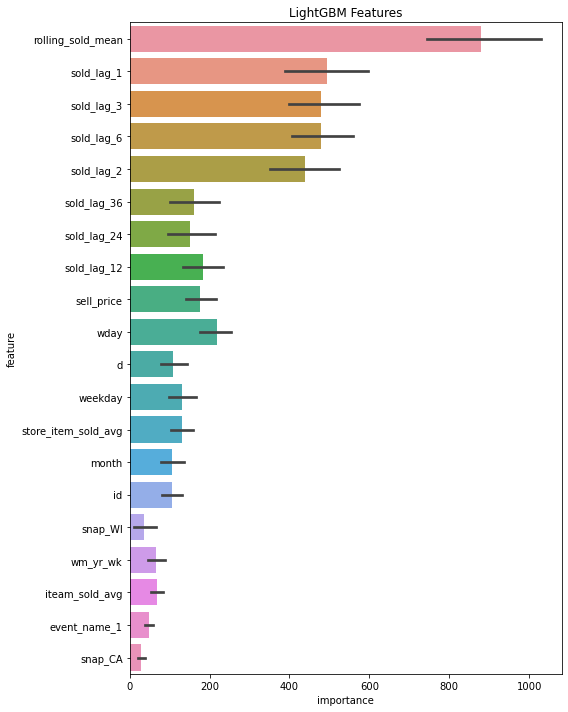

In [36]:
feature_importance_df = pd.DataFrame()
features = [f for f in df.columns if f != 'sold']
for filename in os.listdir('/home/AHub'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()
    
display_importances(feature_importance_df)